# **Библиотеки**

In [ ]:
# pip install numpy scipy matplotlib autograd quantecon ortools z3-solver sympy scikit-learn POT

  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.9/36.9 MB 16.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 17.9 MB/s eta 0:00:00a 0:00:01
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [POT]4/6 [scikit-learn]
Note: you may need to restart the kernel to use updated packages.


In [24]:
import numpy as np
import scipy.linalg as sl
import scipy.optimize as sco
import matplotlib.pyplot as plt
import autograd
from autograd import grad, jacobian
import quantecon as qe
from quantecon import LinearStateSpace, MarkovChain
from quantecon.optimize.linprog_simplex import linprog_simplex
from ortools.linear_solver import pywraplp
import z3
import sympy
from sympy import Eq, Symbol, solve
from sympy.abc import x, a, s, d, A  
from sympy.solvers.simplex import lpmax, lpmin
import sklearn.decomposition as sk
import ot 
from scipy.stats import norm
from typing import Tuple, Union
import numpy as np
%matplotlib inline


# *Задание 1*

В библиотеке quantecon неприводимость (несократимость) проверяет-
ся путём проверки того, образует ли марковская цепь сильно связанный
граф.
Другой способ проверки несократимости — с помощью следующего
утверждения:
Матрица 𝐴 неприводима тогда и только тогда, когда ∑𝑛−1
𝑘=0 𝐴𝑘
является строго положительной матрицей.
Основываясь на этом утверждении, напишите функцию для проверки
неприводимости. Протестируйте на примерах приводимых и неприво-
димых матриц.

Код пытается импортировать scipy.sparse и отмечает в _HAS_SCIPY, чтобы по возможности работать с разреженными матрицами; при отсутствии scipy делает запасные присвоения None. Функция _ensure_square проверяет и возвращает, что вход — квадратная матрица (поддерживает и sparse), а _check_nonnegative убеждается, что матрица не содержит существенных отрицательных элементов с учётом порога tol, иначе бросает ValueError.

In [25]:


try:
    from scipy import sparse
    from scipy.sparse.csgraph import connected_components
    _HAS_SCIPY = True
except Exception:
    sparse = None
    connected_components = None
    _HAS_SCIPY = False

ArrayLike = Union[np.ndarray, "sparse.spmatrix"]  


def _ensure_square(A: ArrayLike) -> ArrayLike:
    if _HAS_SCIPY and sparse.issparse(A):
        if A.shape[0] != A.shape[1]:
            raise ValueError("Матрица должна быть квадратной")
        return A
    arr = np.asarray(A)
    if arr.ndim != 2 or arr.shape[0] != arr.shape[1]:
        raise ValueError("Матрица должна быть квадратной")
    return arr


def _check_nonnegative(A: ArrayLike, tol: float) -> None:
    if _HAS_SCIPY and sparse.issparse(A):
        if A.data.size > 0 and np.any(A.data < -tol):
            raise ValueError("Матрица содержит существенные отрицательные элементы по data")
    else:
        A = np.asarray(A)
        if np.any(A < -tol):
            raise ValueError("Матрица содержит существенные отрицательные элементы")

## *def is_irreducible_by_sum*

Реализует проверку по теореме S = I + A + ... + A^{n-1}: последовательно накапливает степени A и проверяет, что все элементы S > tol; поддерживает ранний выход и разреженные матрицы (scipy.sparse). При return_sum=True возвращает также плотную матрицу S для отладки, иначе возвращает булево значение неприводимости.

In [26]:
def is_irreducible_by_sum(
    A: ArrayLike,
    tol: float = 1e-12,
    return_sum: bool = False,
) -> Union[bool, Tuple[bool, np.ndarray]]:
  
    A = _ensure_square(A)
    _check_nonnegative(A, tol)
    n = A.shape[0]

    if n == 0:
        raise ValueError("Матрица нулевого размера не поддерживается")

    if _HAS_SCIPY and sparse.issparse(A):
        A = A.tocsr().astype(float)
        I = sparse.eye(n, format="csr", dtype=float)
        S = I.copy()
        power = I.copy()
        for k in range(1, n):
            power = power.dot(A)
            S += power
            if (k % 5) == 0 or k == n - 1:
                S_dense = S.toarray()
                if np.all(S_dense > tol):
                    if return_sum:
                        return True, S_dense
                    return True
        S_dense = S.toarray()
        is_irred = np.all(S_dense > tol)
        if return_sum:
            return bool(is_irred), S_dense
        return bool(is_irred)

    A = np.asarray(A, dtype=float)
    I = np.eye(n, dtype=float)
    S = I.copy()
    power = I.copy()
    for k in range(1, n):
        power = power.dot(A)
        S += power
        if (k % 5) == 0 or k == n - 1:
            if np.all(S > tol):
                if return_sum:
                    return True, S
                return True
    is_irred = np.all(S > tol)
    if return_sum:
        return bool(is_irred), S
    return bool(is_irred)


## **def is_irreducible_by_graph**
Построивает ориентированный граф смежности (ребро i→j, если A[i,j] > tol) и использует scipy.sparse.csgraph.connected_components с connection="strong" для проверки сильной связности. Возвращает True, если граф состоит из одной strongly connected component; требует установленный scipy и валидную неотрицательную квадратную матрицу.


In [27]:
def is_irreducible_by_graph(A: ArrayLike, tol: float = 1e-12) -> bool:
    # проверка на дурака, а то мало ли 
    if not _HAS_SCIPY:
        raise RuntimeError("scipy не доступен, установи поджалуйста или перепроверь его ведь для проверки методом графа требуется scipy")
    A = _ensure_square(A)
    _check_nonnegative(A, tol)
    n = A.shape[0]
    if n == 0:
        raise ValueError("Матрица нулевого размера не поддерживается")

    if sparse.issparse(A):
        A_csr = A.tocsr()
        A_adj = (A_csr > tol).astype(int)
    else:
        A_arr = np.asarray(A, dtype=float)
        A_adj = sparse.csr_matrix((A_arr > tol).astype(int))

    n_comp, labels = connected_components(csgraph=A_adj, directed=True, connection="strong")
    return int(n_comp) == 1


## **def run_examples()**
Собирает набор тестовых матриц и последовательно прогоняет над ними обе проверки, печатая результаты или ошибки. Удобна для быстрой демонстрации работы модуля и manual-диагностики --> главное, чтобы все было четко и дай Бог работало 

In [28]:
def run_examples():
    examples = {
        "irreducible_all_positive_2x2": np.array([[0.5, 0.5], [0.5, 0.5]]),
        "irreducible_cycle_3": np.array([[0, 1, 0],
                                         [0, 0, 1],
                                         [1, 0, 0]]),
        "irreducible_cycle_2": np.array([[0, 1],
                                         [1, 0]]),
        "reducible_block_upper": np.array([[0.5, 0.5, 0.0],
                                           [0.0, 0.7, 0.3],
                                           [0.0, 0.0, 1.0]]),
        "reducible_block_diag": np.array([[1.0, 0.0, 0.0],
                                          [0.0, 0.3, 0.7],
                                          [0.0, 0.2, 0.8]]),
        "irreducible_with_zeros_3": np.array([[0, 1, 0],
                                              [0, 0, 1],
                                              [0.4, 0.1, 0.5]]),
        "identity_3": np.eye(3),
    }

    print("=== Проверка методом суммы степеней S = I + A + ... + A^{n-1} ===")
    for name, M in examples.items():
        try:
            irred, S = is_irreducible_by_sum(M, return_sum=True)
            print(f"{name:30} | irreducible: {irred}")
        except Exception as e:
            print(f"{name:30} | error: {e}")

    if _HAS_SCIPY:
        print("\n=== Проверка методом графа (strong connectivity) ===")
        for name, M in examples.items():
            try:
                irred_graph = is_irreducible_by_graph(M)
                print(f"{name:30} | irreducible (graph): {irred_graph}")
            except Exception as e:
                print(f"{name:30} | error (graph): {e}")
    else:
        print("\nscipy не установлен — пропускаю проверку методом графа.")


if __name__ == "__main__":
    run_examples()

=== Проверка методом суммы степеней S = I + A + ... + A^{n-1} ===
irreducible_all_positive_2x2   | irreducible: True
irreducible_cycle_3            | irreducible: True
irreducible_cycle_2            | irreducible: True
reducible_block_upper          | irreducible: False
reducible_block_diag           | irreducible: False
irreducible_with_zeros_3       | irreducible: True
identity_3                     | irreducible: False

=== Проверка методом графа (strong connectivity) ===
irreducible_all_positive_2x2   | irreducible (graph): True
irreducible_cycle_3            | irreducible (graph): True
irreducible_cycle_2            | irreducible (graph): True
reducible_block_upper          | irreducible (graph): False
reducible_block_diag           | irreducible (graph): False
irreducible_with_zeros_3       | irreducible (graph): True
identity_3                     | irreducible (graph): False


# **Задание 2**

### №2. VAR(2) — задание

Задачи:
1. Постройте представление модели в виде линейной системы в пространстве состояний (LSS).  
2. Постройте графики симуляций компонент \(x_t\), \(y_t\), \(z_t\).

Дополнительно (по желанию): проверьте устойчивость процесса, найдя собственные значения companion-матрицы и оценив их модули.

In [29]:
# Тип дано 
Phi1 = np.array([[1.0,0,0],[0,0.6,0],[0,1,0]])
Phi2 = np.array([[0,1,0],[0,-0.58,0],[0,0,0.9]])

Построение companion‑представления (A, B, C), A — companion‑матрица размерности 6×6, составленная как [[Phi1, Phi2]; [I, 0]], она переводит VAR(2) в LSS вид x_{t+1}=A x_t + B ε_{t+1}, а далее просто подставляет шок только в первые три компоненты состояния, а C выбирает первые три компоненты состояния как наблюдаемые (y_t = C x_t) - бинго 

In [30]:
m = 3
A = np.vstack([np.hstack([Phi1,Phi2]), np.hstack([np.eye(m), np.zeros((m,m))])])
B = np.vstack([np.eye(m), np.zeros((m,m))])
C = np.hstack([np.eye(m), np.zeros((m,m))])

Параметры симуляции и инициализация генератора, 
T задаёт длину серии (можем хоть 1000 как на паре), n_sims — число независимых симуляций, в свою же очередь rng — генератор случайных чисел с фиксированным seed для воспроизводимости (это для себя) z же — это начальное состояние длины 6, и w_paths резервирует память для хранения всех траекторий.

In [31]:
T = 200
n_sims = 5
rng = np.random.default_rng(12345)
z = np.zeros(2*m)  # начальное состояние [w0; w_{-1}] = 0

w_paths = np.zeros((n_sims, T, m))
for s in range(n_sims):
    z = np.zeros(2*m)
    for t in range(T):
        eps = rng.standard_normal(m)
        z = A.dot(z) + B.dot(eps)
        w_paths[s,t,:] = C.dot(z)




time — массив шагов времени от 1 до T для оси абсцисс; names содержит метки для трёх компонент процесса. Это упрощает подписывание графиков и их читаемость. Далее еще строим графики, это и ежу понятно:)))) 

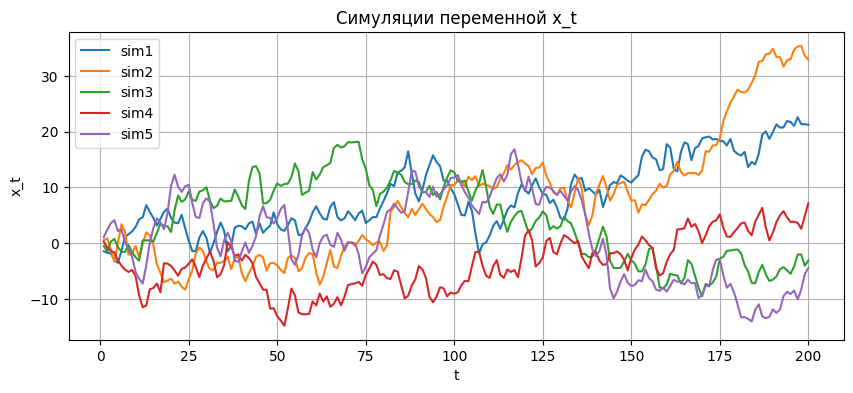

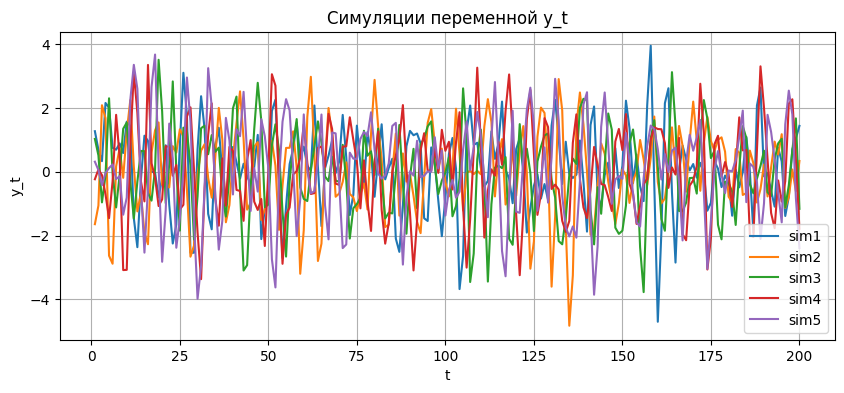

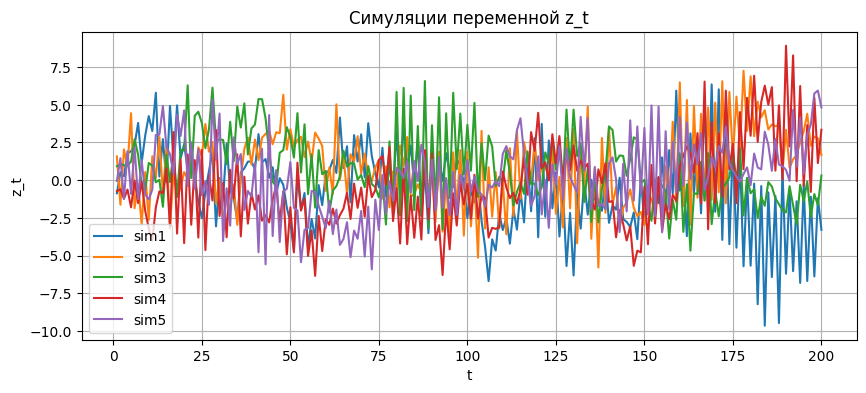

In [32]:
time = np.arange(1, T+1)
names = ["x_t","y_t","z_t"]
for j in range(m):
    plt.figure(figsize=(10,4))
    for s in range(n_sims):
        plt.plot(time, w_paths[s,:,j], label=f"sim{s+1}")
    plt.title(f"Симуляции переменной {names[j]}")
    plt.xlabel("t"); plt.ylabel(names[j])
    plt.legend(); plt.grid(True)
    plt.show()

# **Задание 3**

Реализуйте QR алгоритм поиска собственных значений2. Алгоритм дол-
жен автоматически останавливаться при достижении заданной точности.
1Подумайте, как оно связано с представлением AR.
2Не изобретайте велосипеды, используйте np.linalg. QR алгоритм, тем не менее, напишите сами.


определяется функция для нахождения собственных значений с параметрами точности, максимума итераций и опционального сдвига

In [33]:
def qr_eig_stable(A, tol=1e-10, maxiter=5000, use_shift=True, verbose=False):
   
    # Подготовка матрицы (Матрица приводится к комплексному типу (на случай комплексных собственных значений), проверяется ненулевой размер и создаётся рабочая копия)
    A = np.array(A, dtype=complex)
    n = A.shape[0]
    if n == 0:
        return np.array([], dtype=complex)
    Ak = A.copy()


    # Это вспомогатеьная функция, она вычисляет максимальный по модулю внедиагональный элемент — используется как критерий сходимости
    def offdiag_max(mat):
        m = mat.copy()
        np.fill_diagonal(m, 0)
        return np.max(np.abs(m))



    # Сам алгоритм на каждой итерации проверяется, достаточно ли малы внедиагональные элементы; если да — алгоритм сошёлся, возвращаются диагональные элементы как собственные значения.

    for it in range(1, maxiter+1):
        # Сходимость: все внедиагональные элементы малы
        if offdiag_max(Ak) < tol:
            if verbose:
                print(f"Converged in {it-1} iterations, offdiag max {offdiag_max(Ak):.2e}")
            return np.diag(Ak)
        # сдвиг Уилкинсона по нижнему 2x2 блоку 
        mu = 0+0j
        if use_shift and n >= 2:
            B = Ak[-2:, -2:]
            tr = B[0,0] + B[1,1]
            det = B[0,0]*B[1,1] - B[0,1]*B[1,0]
            disc = tr*tr - 4*det
            sqrt_disc = np.sqrt(disc)
            mu1 = (tr + sqrt_disc)/2
            mu2 = (tr - sqrt_disc)/2
            mu = mu1 if abs(mu1 - Ak[-1,-1]) < abs(mu2 - Ak[-1,-1]) else mu2
        # QR-шаг и обновление матрицы бингоооооооооооооооооооооооо
        Q, R = np.linalg.qr(Ak - mu*np.eye(n, dtype=complex))
        Ak = R.dot(Q) + mu*np.eye(n, dtype=complex)

    # Если не сошлось — вернём np.linalg.eigvals как запасной вариант, а то мало ли (вдруг я кривой)
    return np.linalg.eigvals(A)
